## Predicting Kickstarter Success

### MSDS 7331-404: Lab 1
Travis Deason
Michael Landrum
Vanessa Torres

### Business Understanding

The success of a Kickstarter projects may have some association with variables like goal, number of backers, amount of money pledged, and a few other key features.  This study focuses on producing a model that could help determine those said features in order to help predict the success of a Kickstarter project. The methodology includes brainstorming, data exploration and multidimensional data analysis. The following models could be helpful in determining and improving the success rate of Kickstarter projects

The dataset we used is a list of Kaggle reports compiled in February 2018.  It contains a total of 378661 individual observations, and reports if each of those individual project were successful or failed.  The benefit of understanding this dataset is that it would put you, as the investor, in a stronger position to decide which Kickstarters are more likely to be successful, and which are likely to fail.

If we were using a prediction algorithm, we could maintain a randomly selected holdout set to validate our model.  Alternatively, we could use a cross validated set. 

### Data Meaning Type

Extracted from Kickstarter, https://www.kaggle.com/kemical/kickstarter-projects/data the datasets in this study, are projects that started on the Kickstarter platform in 2016 and 2018. The 2016 file consists of 323750 observations while the 2018 file has 378661 observations. Both datasets have 13 common explanatory variables - 6 categorical and 7 continuous. The categorical variables that also have subtypes are main_category (15), country (21), currency (13), state (5), and category (>100). Noticeably, when reading the 2016.csv file, python reads 4 additional “unnamed” columns and in the 2018 file, there are 2 additional variables, “usd_pledged_real” and “usd_goal_real” 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as scs
import time
import json
import nltk
from collections import Counter
from sklearn import ensemble as ens
from sklearn import linear_model as lm
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid", palette="pastel", color_codes=True)

In [2]:
df_ks16 = pd.read_csv("../vanessatorres/desktop/kickstarter-projects/ks-projects-201612.csv", encoding='ISO-8859-14')
df_ks16.drop(['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

/Users/vanessatorres/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cols = df_ks16.columns.tolist()
for entry in np.arange(0,len(cols),1):
    cols[entry] = cols[entry].rstrip()
df_ks16.columns = cols
df_ks16.columns

df_ks16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 13 columns):
ID               323750 non-null int64
name             323748 non-null object
category         323745 non-null object
main_category    323750 non-null object
currency         323750 non-null object
deadline         323750 non-null object
goal             323750 non-null object
launched         323750 non-null object
pledged          323750 non-null object
state            323750 non-null object
backers          323750 non-null object
country          323750 non-null object
usd pledged      319960 non-null object
dtypes: int64(1), object(12)
memory usage: 32.1+ MB


In [4]:
ids_2016 = df_ks16['ID'].values

In [5]:
df_ks18 = pd.read_csv("../vanessatorres/desktop/kickstarter-projects/ks-projects-201801.csv", encoding='ISO-8859-14')
df_ks18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [6]:
df_ks18.sample(3).T

324574  \
ID                                         723140450   
name              Nova Cry: 2nd Printing! (Canceled)   
category                              Tabletop Games   
main_category                                  Games   
currency                                         USD   
deadline                                  2016-07-01   
goal                                           10000   
launched                         2016-06-01 15:00:30   
pledged                                          217   
state                                       canceled   
backers                                            3   
country                                           US   
usd pledged                                      217   
usd_pledged_real                                 217   
usd_goal_real                                  10000   

                                                             365174  \
ID                                                        930550832   
name              Raptor Claw: A Hunting, EDC, and Outdoor Lifes...   
category                                             Product Design   
main_category                                                Design   
currency                                                        USD   
deadline                                                 2017-04-17   
goal                                                          40000   
launched                                        2017-03-09 17:07:28   
pledged                                                        2335   
state                                                        failed   
backers                                                          13   
country                                                          US   
usd pledged                                                     860   
usd_pledged_real                                               2335   
usd_goal_real                                                 40000   

                                                             327203  
ID                                                        736523985  
name              Brookdale College Center for WWII Studies 2012...  
category                                                  Webseries  
main_category                                          Film & Video  
currency                                                        USD  
deadline                                                 2012-09-28  
goal                                                          25000  
launched                                        2012-08-29 23:55:43  
pledged                                                         200  
state                                                        failed  
backers                                                           3  
country                                                          US  
usd pledged                                                     200  
usd_pledged_real                                                200  
usd_goal_real                                                 25000

In [7]:
data = df_ks18
data['state'].value_counts(1)

failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: state, dtype: float64

As previously stated, the dataset consists of 378661 observations.  These observations are all individual kickstarters which occurred over the past few years.  The included features in this dataset are as follows:

| Attribute | Description | Attribute Data Type |
| --- | --- | --- |
| ID | A unique identifier for each kickstarter project | int |
| Backers | Number of people who backed the kickstarter program | int |
| Category | Product category which the Kickstarter falls into (set of 159) | str |
| Country | Country origin for the Kickstarter campaign | str |
| Currency | Type of money used in goal and pledged | str |
| Dataset | Which dataset the Kickstarter came from (either 2018 or 2016) | int  |
| Goal | Amount of money the Kickstarter was looking for (in native currency) | float |
| Launched | Time when the Kickstarter was launched | timestamp |
| Main_category | Set of 15 different larger categories (similiar to category) | int |
| Name | Name of the Kickstarter project | str |
| Pledged | Value pledged to Kickstarter in native currency | float |
| State | Condition of Kickstarter at time of survey {failed, successful, canceled, live, undefined, suspended}| str | 
| USD pledged | Value pledged in USD | float |
| USD_pledged_real | This is an attempt to measure the actual USD based on currency values for the amount pledged at the time by the creator of the dataset| float |
| USD_goal_real | This is an attempt to measure the actual USD based on currency values at the time for the Kickstarter goal by the creator of the dataset | float |


### Data Quality 

In [8]:
with open('desktop/kickstarter-projects/ks-projects-201612.csv', encoding='latin1') as fh:
        txt = fh.read()

body = []
headers = txt.split('\n')[0].strip().split(',')
for line in txt.split('\n')[1:]:
    body.append(line.split(','))

headers = [i for i in headers if len(i) > 3]

In [9]:
ukn = len(headers) + 1
while len(headers) < 25:
    headers.append('Unnamed: {}'.format(ukn))
    ukn += 1

data_16 = pd.DataFrame(body)
data_16.columns = headers
data_16.columns = [col.lower().strip() for col in data_16.columns]


data_18 = pd.read_csv('desktop/kickstarter-projects/ks-projects-201801.csv')
data_18.columns = [col.lower().strip() for col in data_18.columns]

In [10]:
data_16.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'unnamed: 13', 'unnamed: 14', 'unnamed: 15', 'unnamed: 16',
       'unnamed: 17', 'unnamed: 18', 'unnamed: 19', 'unnamed: 20',
       'unnamed: 21', 'unnamed: 22', 'unnamed: 23', 'unnamed: 24',
       'unnamed: 25'],
      dtype='object')

In [11]:
data_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
id                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


**There are several datapoints which are missing a significant amount of data in this dataset**

The Unnamed columns (13-16) are artifact data due to commas in the pledged amount or Name field, This could have been solved by using a .tsv or some other means of deliminating the data

    -  Evidence of this is shown below, where 6 values are taken from "unnamed: 14" (where it is not null) and each of those values contains 2 commas in the name field.

In [12]:
iiter = data_16[data_16['unnamed: 14'].apply(lambda x: type(x) is str)]\
            .sample(6)[['name', 'category', 'main_category']].values
for x in iiter:
    print(','.join(i for i in x))

574780336,Roberto lomeli first e.p,Music
775862038,Backpack - Inyo Packs classic Daypacks - Bag,Accessories
1213110026,OosImaginary Summer Tour Project ,Dance
73314273,AMFI Students Graduation Presentation,Couture
1229811014,Ghost Heart: Book Three of The PSS Chronicles,Young Adult
1997513795,Game Over Remix,Tabletop Games


Additionally, the creator of the dataset attempted to time adjust the values for USD pledged in the 2018 dataset, but this was not completed for the 2016 dataset.
    -  Because of this, and the complexity associated with fixing datapoints which contain columns in them, we will be sticking to the 2018 dataset for the remainder of this analysis

In [13]:
ids_2016 = data_16.index

In [14]:
"{:.1f}%".format(float(data_18.set_index('id').loc[ids_2016].shape[0])\
                                / data_16.shape[0] * 100)

'100.0%'

    -  This generalization appears to be valid, because the 2018 dataset contains all of the values from the 2016 dataset as well
    
There are 4 datapoints which are missing names. Since this is only 4 datapoints out of 378661, we will assign these datapoint a randomly generated number as a name

In [15]:
data_18[~data_18['name'].apply(lambda x: type(x) is str)].iloc[:,:7]

id name        category main_category currency    deadline  \
166851  1848699072  NaN  Narrative Film  Film & Video      USD  2012-02-29   
307234   634871725  NaN     Video Games         Games      GBP  2013-01-06   
309991   648853978  NaN  Product Design        Design      USD  2016-07-18   
338931   796533179  NaN        Painting           Art      USD  2011-12-05   

            goal  
166851  200000.0  
307234    2000.0  
309991    2500.0  
338931   35000.0

In [16]:
rand_vars = np.random.randint(30000, 500000, size=4)
print(rand_vars)

[ 50911 456542 370352 324626]


In [17]:
noname = data_18[~data_18['name'].apply(lambda x: type(x) is str)].index

data_18.loc[noname , 'name'] = \
    pd.Series(np.random.choice(rand_vars, 4, replace=False)).astype(str)

Additionally, the 2018 dataset has 3797 values where the USD pledged value is null.  For our purpose, we will drop this column and use the usd_pledged_real column to identify if our project has met it's goal.

For the sake of keeping everything uniform, we will keep all monetary values in USD for the remainder of this report, so they can be directly compared. 

In [18]:
data_18[np.isnan(data_18['usd pledged'])].shape

(3797, 15)

In [19]:
excl = {'usd pledged', 'goal', 'pledged'}
df = data_18[[col for col in data_18.columns if col not in excl]]

### Simple Statistics

Removing redundant and null values has left us with only 3 continuous features in the dataset. ID is also included below.

In [20]:
df.describe()

id        backers  usd_pledged_real  usd_goal_real
count  3.786610e+05  378661.000000      3.786610e+05   3.786610e+05
mean   1.074731e+09     105.617476      9.058924e+03   4.545440e+04
std    6.190862e+08     907.185035      9.097334e+04   1.152950e+06
min    5.971000e+03       0.000000      0.000000e+00   1.000000e-02
25%    5.382635e+08       2.000000      3.100000e+01   2.000000e+03
50%    1.075276e+09      12.000000      6.243300e+02   5.500000e+03
75%    1.610149e+09      56.000000      4.050000e+03   1.550000e+04
max    2.147476e+09  219382.000000      2.033899e+07   1.663614e+08

Based on our summary statistics, half of all Kickstarter campaigns have no more than 2 backers, make less than 31 dollars, and have a goal of 2,000 dollars or less.  However, some Kickstarters campaigns, have goals of over 10 million dollars, or more than 200,000 backers, and generate at 2 million dollars or more. This dataset clearly has a lot of range.

We will first look at how backers are distributed, then usd_pledged_real and lastly usd_goal_real. 

#### Backers

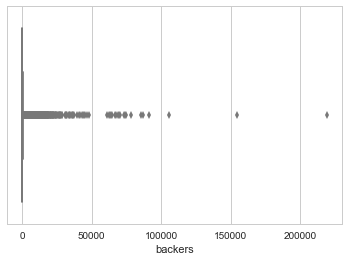

In [21]:
sns.boxplot(df['backers']);

Based on the above boxplot, we can see that this dataset has a lot of Kickstarter campaigns  with 0 backers, and most of them have less than 5,000 backers. With this information, this attribute is a strong candidate for a log transformation.

In efforts to get a better picture of what the data is trying to tell us, lets look at a violin plot of the log distribution.

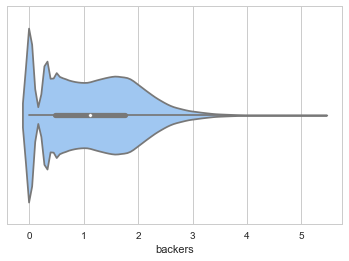

In [22]:
sns.violinplot(np.log10(df['backers'] + 1));

With the information provided from both the boxplot and violin plot, it is clear, that a small percent of the Kickstarter campaigns get a larger portion of the data. There is considerable evidence to suggest that this feature is non-bayesian, but is consistent in following a power law distribution.  Further evidence of this can also be found in that nearly 50% of all backers contributed to the top 1% of all Kickstarter campaigns (as shown below).

In [23]:
bkrs = df['backers']
_50 = float(bkrs[bkrs >= bkrs.quantile(.50)].sum()) / bkrs.sum() * 100
_75 = float(bkrs[bkrs >= bkrs.quantile(.75)].sum()) / bkrs.sum() * 100
_90 = float(bkrs[bkrs >= bkrs.quantile(.90)].sum()) / bkrs.sum() * 100
_99 = float(bkrs[bkrs >= bkrs.quantile(.99)].sum()) / bkrs.sum() * 100
_999 = float(bkrs[bkrs >= bkrs.quantile(.999)].sum()) / bkrs.sum() * 100

tmplt = '{:.2f}% of the total number of backers go to the top {}% of kickstarters'

print(tmplt.format(_50, '50'))
print(tmplt.format(_75, '25'))
print(tmplt.format(_90, '10'))
print(tmplt.format(_99, '1'))
print(tmplt.format(_999, '0.1'))

98.69% of the total number of backers go to the top 50% of kickstarters
91.84% of the total number of backers go to the top 25% of kickstarters
78.22% of the total number of backers go to the top 10% of kickstarters
42.35% of the total number of backers go to the top 1% of kickstarters
17.22% of the total number of backers go to the top 0.1% of kickstarters


#### usd_pledged_real

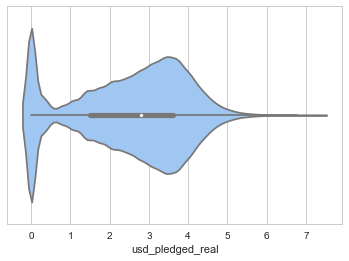

In [24]:
sns.violinplot(np.log10(df['usd_pledged_real'] + 1));

In [25]:
bkrs = df['usd_pledged_real']
_50 = float(bkrs[bkrs >= bkrs.quantile(.50)].sum()) / bkrs.sum() * 100
_75 = float(bkrs[bkrs >= bkrs.quantile(.75)].sum()) / bkrs.sum() * 100
_90 = float(bkrs[bkrs >= bkrs.quantile(.90)].sum()) / bkrs.sum() * 100
_99 = float(bkrs[bkrs >= bkrs.quantile(.99)].sum()) / bkrs.sum() * 100
_999 = float(bkrs[bkrs >= bkrs.quantile(.999)].sum()) / bkrs.sum() * 100

tmplt = '{:.2f}% of the quantity of funding go to the top {}% of kickstarters'

print(tmplt.format(_50, '50'))
print(tmplt.format(_75, '25'))
print(tmplt.format(_90, '10'))
print(tmplt.format(_99, '1'))
print(tmplt.format(_999, '0.1'))

99.36% of the quantity of funding go to the top 50% of kickstarters
94.09% of the quantity of funding go to the top 25% of kickstarters
81.61% of the quantity of funding go to the top 10% of kickstarters
47.13% of the quantity of funding go to the top 1% of kickstarters
21.10% of the quantity of funding go to the top 0.1% of kickstarters


Looking at the amount of money pledged and from the violin plot above, we can see a significant representation in the 400 USD to 800 USD range. Furthermore, in a similar manner to the number of backers, half of the dollars pledged, went to the top 1% of all Kickstarter campaigns.

#### usd_goal_real

In [26]:
df.loc[:,'log_goal'] = np.log10(df.loc[:,'usd_goal_real'] + 1)

/Users/vanessatorres/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/vanessatorres/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
df.columns

Index(['id', 'name', 'category', 'main_category', 'currency', 'deadline',
       'launched', 'state', 'backers', 'country', 'usd_pledged_real',
       'usd_goal_real', 'log_goal'],
      dtype='object')

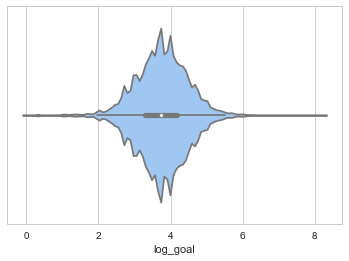

In [28]:
sns.violinplot(df['log_goal']);

After looking at usd_goal_real, and seeing that there were still quite a few Kickstarter campaigns with very high and very low goals, we decided on transforming the data by taking the log of goal. In doing so, we found that the log of goal appears closer to a normal distribution. It's possible that if we only focus on campaigns with goals between 50 USD and
100,000 USD, and ignore fringe campaigns, we may be able to get a better understanding of how most Kickstarters work.

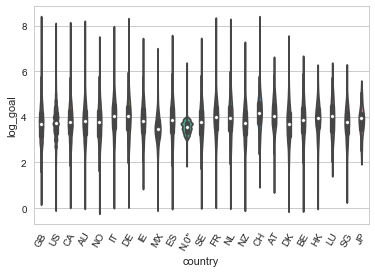

In [29]:
plt.xticks(rotation=60)
vplot= sns.violinplot(x="country", y="log_goal", data=df, figsize=(18, 6))

### Visualize Attributes

In [30]:
df.columns

Index(['id', 'name', 'category', 'main_category', 'currency', 'deadline',
       'launched', 'state', 'backers', 'country', 'usd_pledged_real',
       'usd_goal_real', 'log_goal'],
      dtype='object')

In [31]:
df['duration'] = (df['deadline'].apply(pd.Timestamp)\
    - df['launched'].apply(pd.Timestamp)).apply(lambda x: x.days)
df['launched_month'] = df['launched'].apply(lambda x: pd.Timestamp(x).month)

/Users/vanessatorres/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
dfcopy = df.assign(success=0)
dfcopy.loc[ dfcopy['state']=="successful", 'success' ] = 1
dfcopy.loc[:,'log_backers'] = np.log10(dfcopy.loc[:,'backers'] + 1)
dfcopy.loc[:,'log_usd_goal_real'] = \
    np.log10(dfcopy.loc[:,'usd_goal_real'] + 1)
dfcopy.loc[:,'log_usd_pledged_real'] = \
    np.log10(dfcopy.loc[:,'usd_pledged_real'] + 1)
dfcopy.loc[:,'log_duration'] = \
    np.log10(dfcopy.loc[:,'duration'] + 1)
    

dfcopy = dfcopy.assign(isUS=0)
dfcopy.loc[ dfcopy['country']=="US", 'isUS' ] = 1

### Explore Joint Attributes

In [33]:
df_scatter = dfcopy.drop(['id', 'log_goal', 'isUS',  'usd_pledged_real',
                           'duration', 'usd_goal_real', 'backers'], axis=1)

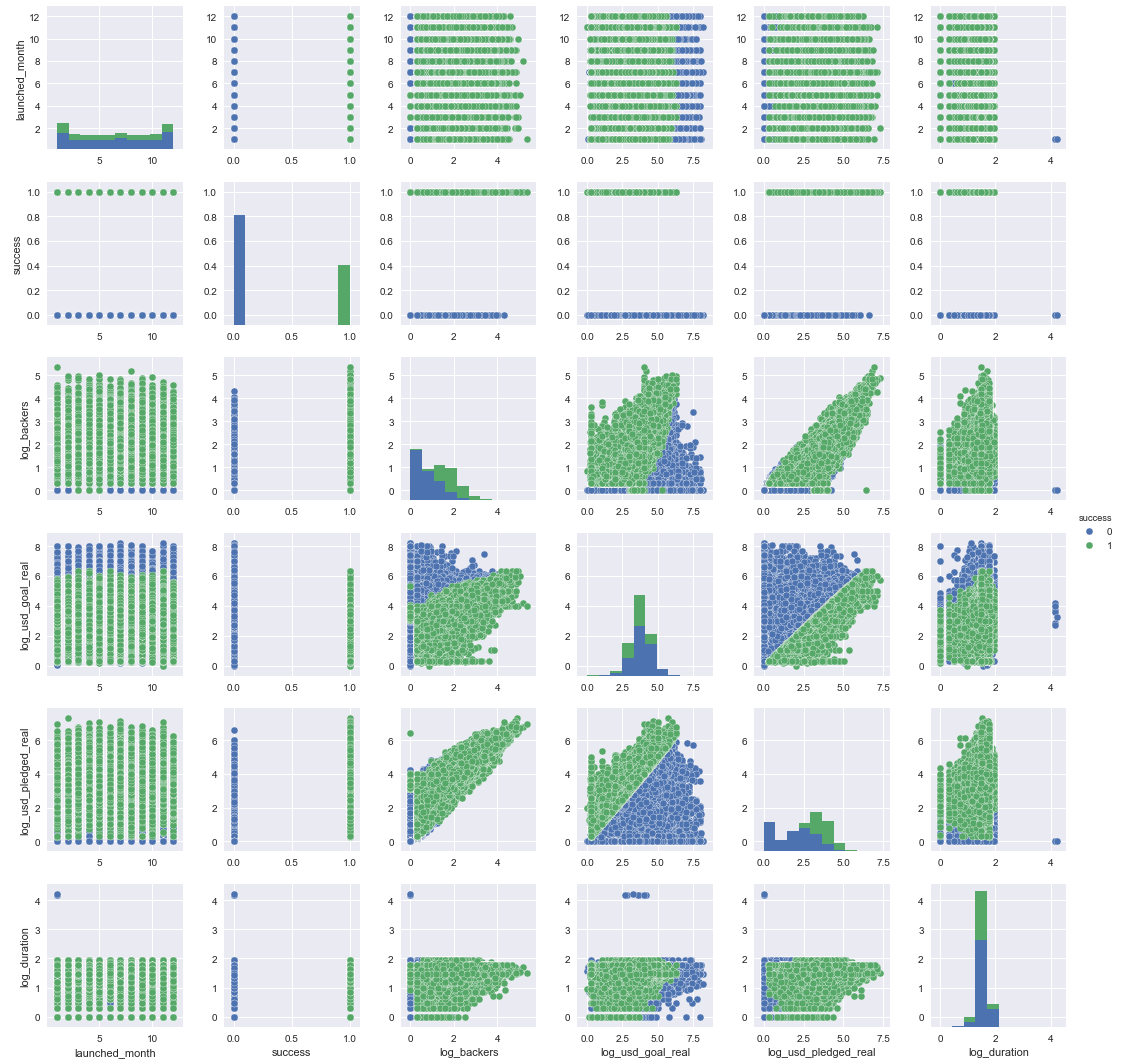

In [34]:
sns.set(style="darkgrid")
sns.pairplot(df_scatter, hue="success");

Base on the scatterplots above, we see little correlation with success from our generated features, kickstarter duration and launched month. However, what we do see, is a robust differential relationship between the number of backers and total goal amount. This relationship serves as a strong predictor for the success rate of a Kickstarter campaign.

In [35]:
one_hot_df = pd.get_dummies(dfcopy, prefix_sep='$', 
               columns=['main_category', 'country'])\
      .drop(['isUS','launched', 'deadline', 'backers',
             'usd_goal_real', 'usd_pledged_real'], axis=1)\
      .drop([x for x in dfcopy.columns if 'log' in x], axis=1)

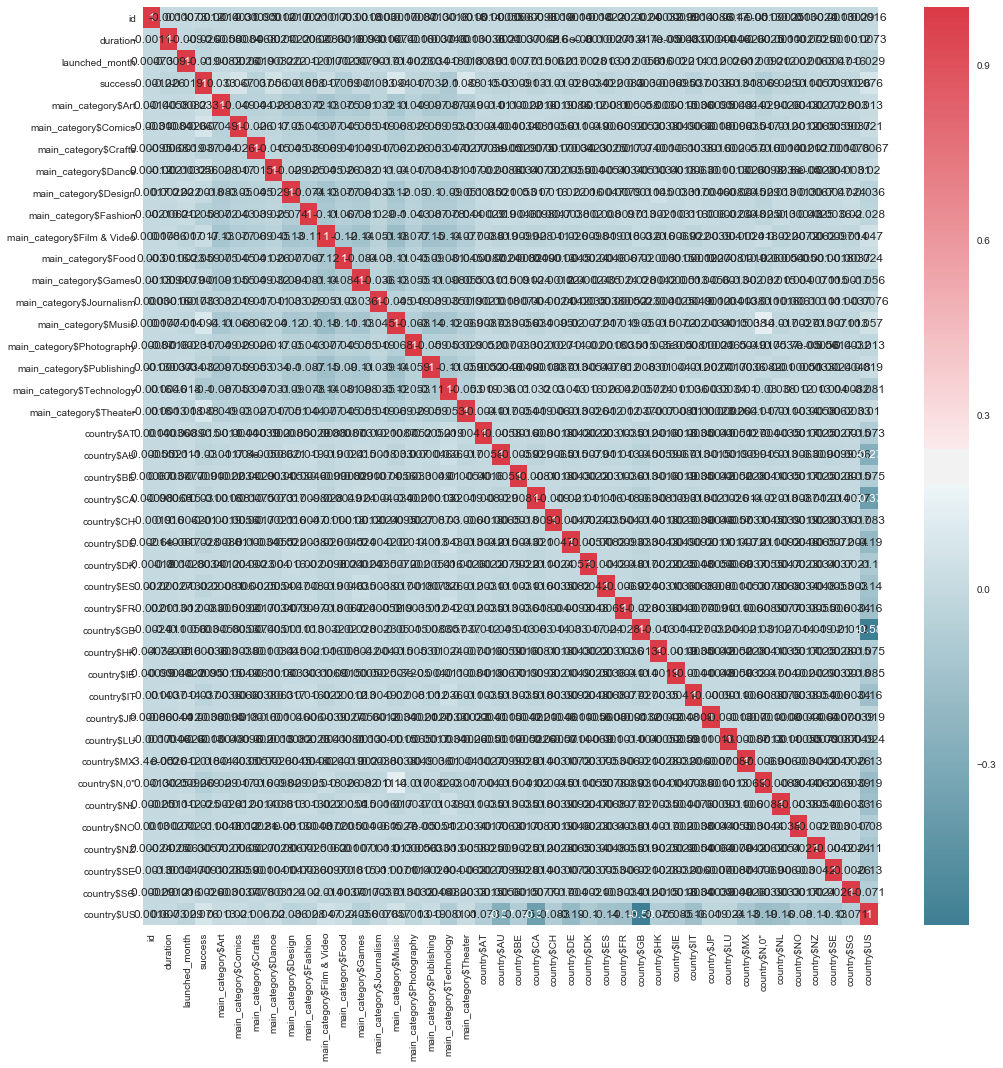

In [36]:
# one_hot_df.columns

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(one_hot_df.corr(), cmap=cmap, annot=True)

f.tight_layout()

Furthermore, we can also see that a successful Kickstarter is highly correlated to categories such as Theater, Music, Dance, and Comics.

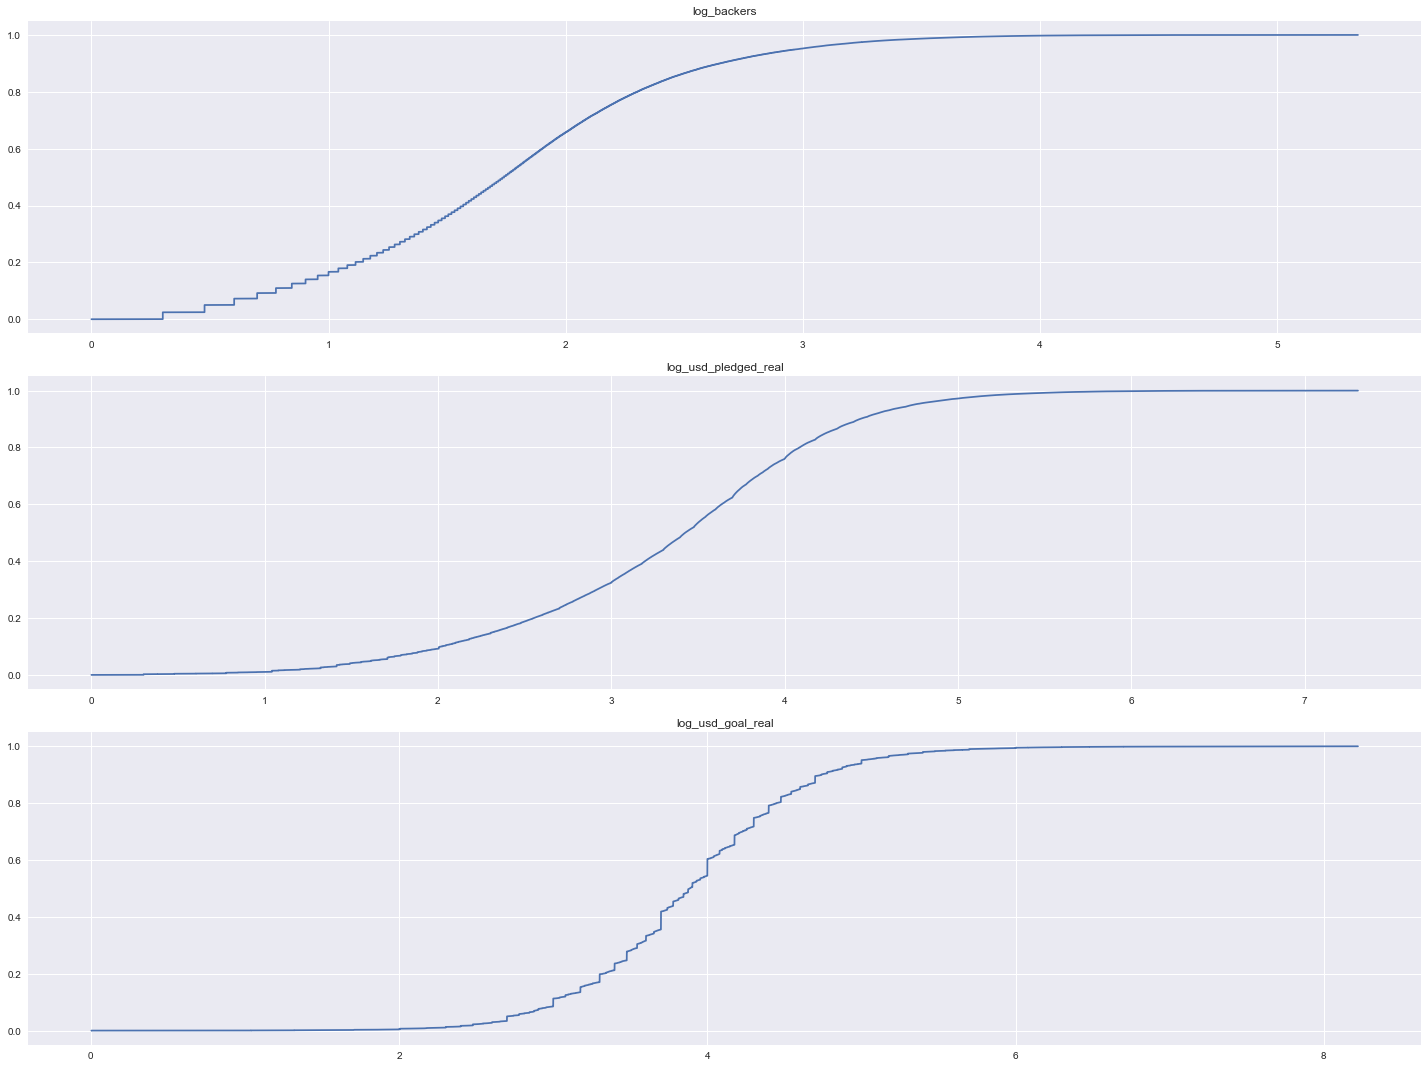

In [37]:
plt.figure(figsize=(20,15))
for fi,feature in enumerate(
        ['log_backers','log_usd_pledged_real','log_usd_goal_real']):
    plt.subplot(3,1,fi+1)
    x_ax = np.sort(dfcopy[feature])
    y_ax = np.cumsum(x_ax)
    y_ax = y_ax/np.max(y_ax)
    plt.plot(x_ax,y_ax)
    plt.title(feature)
    plt.tight_layout()
    
plt.show()

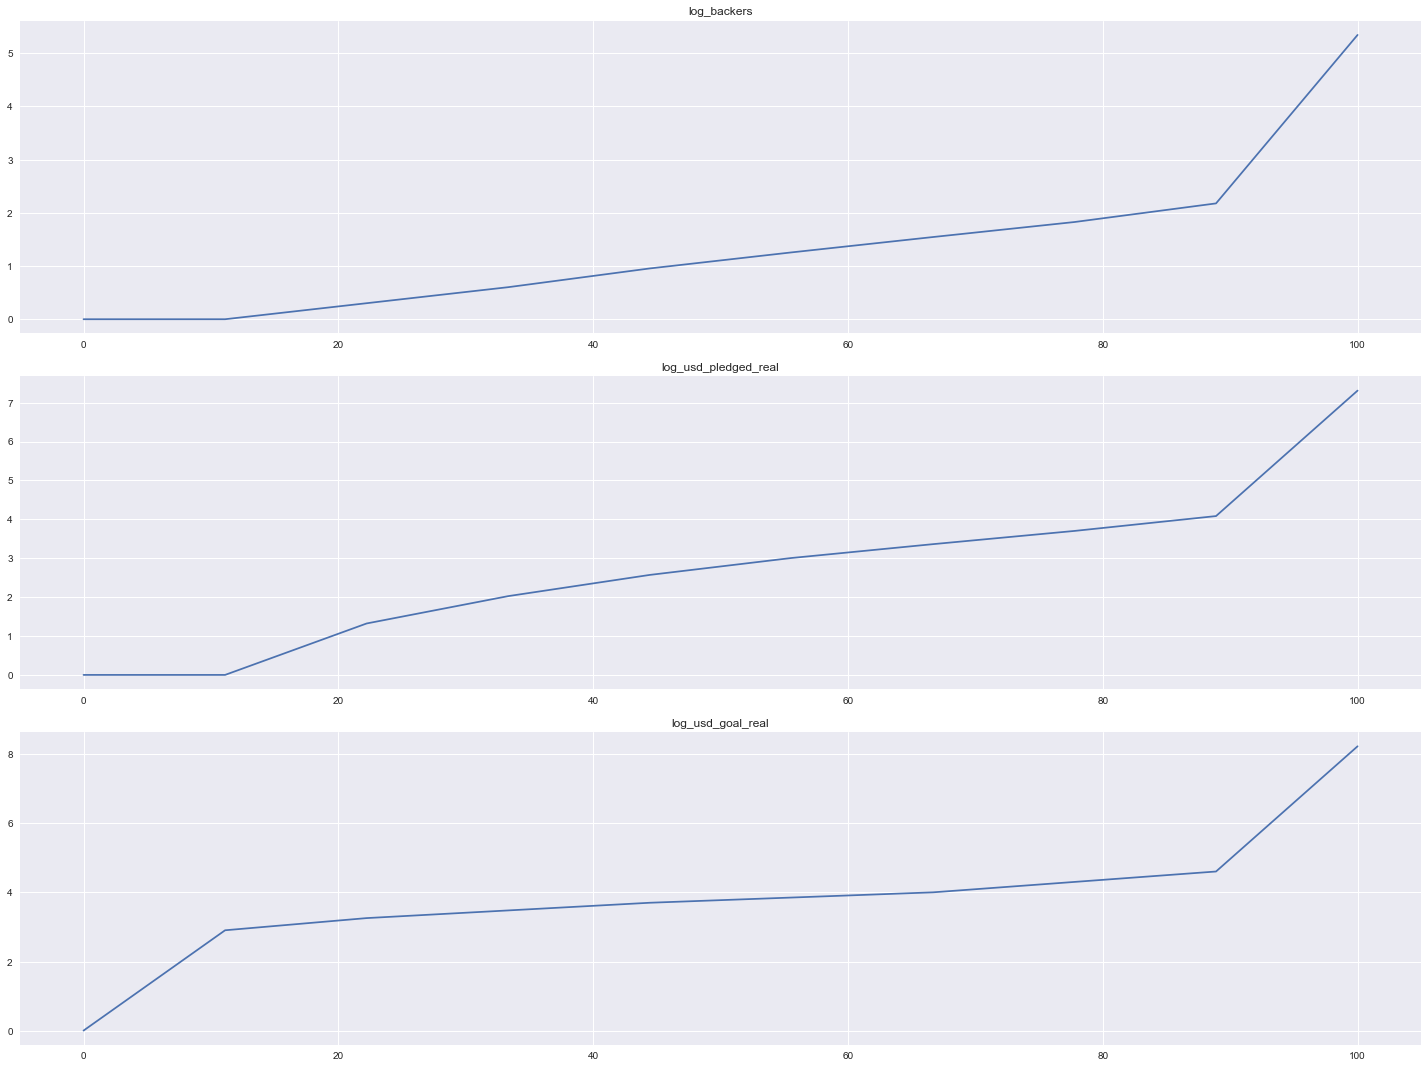

In [38]:
plt.figure(figsize=(20,15))
for fi,feature in enumerate(
    ['log_backers','log_usd_pledged_real','log_usd_goal_real']):
    plt.subplot(3,1,fi+1)
    x_ax = np.linspace(0,100,10)
    y_ax = [np.percentile(dfcopy[feature], x_val) for x_val in x_ax]
    plt.plot(x_ax,y_ax)
    plt.title(feature)
    plt.tight_layout()
    
plt.show()

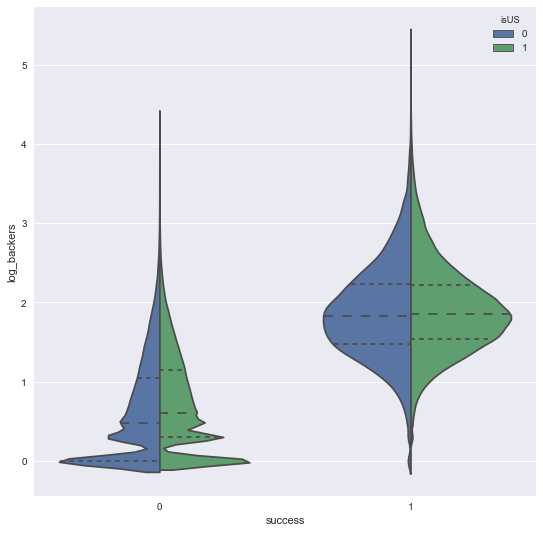

In [39]:
f, ax = plt.subplots(figsize=(9, 9))

sns.violinplot(x="success", y="log_backers", hue="isUS", data=dfcopy, 
               split=True, inner="quart")

### New Features

Since we already extracted length and start year from the given features, we may be able to see if the successful Kickstarters in the US are due to outside funding and it may be possible to draw predictive values based on the day of the week projects are launched.

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv  = '../vanessatorres/desktop/kickstarter-projects/ks-projects-201801.csv'

#import csv and set index column to 'ID'
df = pd.read_csv(csv, index_col = 'ID')
data = pd.read_csv(csv,index_col = 7,parse_dates=[5, 7])
df['launched'] = pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')
df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d')
data['usd_pledged'] = data['usd pledged']
data = data.drop('usd pledged', axis=1)

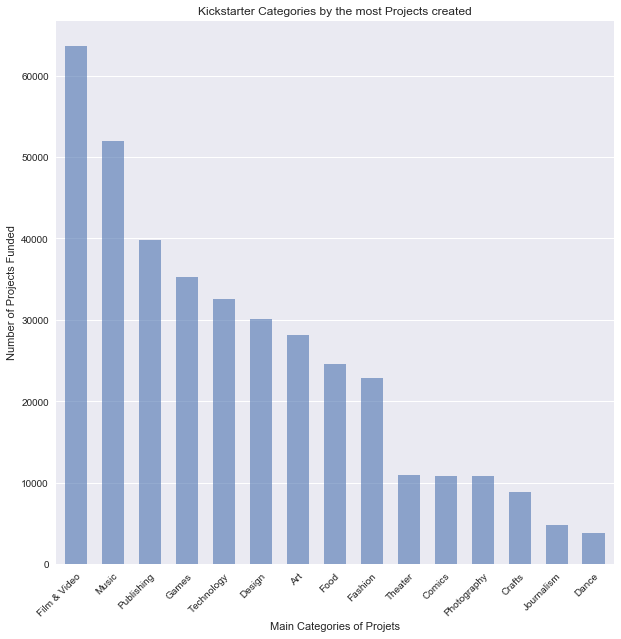

In [41]:
#Plot number of pojects by category
%matplotlib inline
count_data = df['main_category'].value_counts()
ax = count_data.plot(kind = 'bar', figsize = [10, 10], width=0.6, alpha=0.6, grid=False)
ax.set_xticklabels(count_data.index,rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Kickstarter Categories by the most Projects created')
ax.set_xlabel('Main Categories of Projets')
ax.set_ylabel('Number of Projects Funded')
plt.show()

In [42]:
# What is the statistical breakdown of pledge amounts in USD?
df['usd_pledged_real'].max()
df.usd_pledged_real.describe().apply(lambda x: format(x, 'f'))

count      378661.000000
mean         9058.924074
std         90973.343107
min             0.000000
25%            31.000000
50%           624.330000
75%          4050.000000
max      20338986.270000
Name: usd_pledged_real, dtype: object

In [43]:
#The breakdown of state of the various Kickstarter Projects
s_f = df['state'] 
totals = s_f.value_counts()
totals

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [44]:
# Calculate the difference between the amount of USD pledged and the final amount pledged in USD
df['diff'] = (df['usd_pledged_real'] / df['usd pledged']  ) * 100

#Only those projects that were funded with less than 100% difference
funded_differnece_lt_100 = df[df['diff']  < 100]
#Select only the US
usd_pledged_in_us = funded_differnece_lt_100[df['country'] == 'US']
# Only the succesful projects in the US
success = usd_pledged_in_us[usd_pledged_in_us['state'] == 'successful']
success.head()

/Users/vanessatorres/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


name        category  \
ID                                                                              
101109496                            Shonen Boys Enamel Pins!  Graphic Design   
1056242159                               Custom Graffiti Art.        Painting   
1070305978            20 Oldschool and Vintage Poster Prints.  Graphic Design   
1098736561                                   Laughing Phoenix    Film & Video   
1100409267  Anime Neon Genesis Evangelion X Sailor Moon En...             Art   

           main_category currency   deadline    goal            launched  \
ID                                                                         
101109496         Design      USD 2017-11-23   650.0 2017-11-02 19:42:50   
1056242159           Art      USD 2017-08-08    40.0 2017-07-09 23:03:48   
1070305978        Design      USD 2016-10-28     1.0 2016-09-28 23:12:42   
1098736561  Film & Video      USD 2017-08-17     1.0 2017-06-18 01:43:33   
1100409267           Art      USD 2017-12-05  1150.0 2017-11-05 01:50:14   

            pledged       state  backers country  usd pledged  \
ID                                                              
101109496    1852.0  successful       45      US       2014.0   
1056242159    201.0  successful        4      US        215.0   
1070305978     40.0  successful        2      US         60.0   
1098736561     14.0  successful        6      US         15.0   
1100409267   1554.0  successful       36      US       1614.0   

            usd_pledged_real  usd_goal_real       diff  
ID                                                      
101109496             1852.0          650.0  91.956306  
1056242159             201.0           40.0  93.488372  
1070305978              40.0            1.0  66.666667  
1098736561              14.0            1.0  93.333333  
1100409267            1554.0         1150.0  96.282528

In [45]:
year17 = data.loc['2017-01-01':'2017-12-01']

In [46]:
#Total amount pledged at the end of the month in 2017
year17.pledged.loc['2017-01-01':'2017-12-01'].resample('1M').sum()

launched
2017-01-31    49586275.34
2017-02-28    56396252.03
2017-03-31    85705430.98
2017-04-30    66299258.49
2017-05-31    78763209.72
2017-06-30    64333794.38
2017-07-31    65349627.15
2017-08-31    67348811.86
2017-09-30    80293824.08
2017-10-31    78411227.48
2017-11-30    67377320.80
2017-12-31     2575704.74
Freq: M, Name: pledged, dtype: float64

In [47]:
# Find the mean given by in 2017
year17.pledged.loc['2017-01-01':'2017-12-01'].resample('1M').mean()

launched
2017-01-31    11140.479744
2017-02-28    14004.532414
2017-03-31    16324.843996
2017-04-30    15133.361901
2017-05-31    16395.339242
2017-06-30    14283.702127
2017-07-31    15489.364103
2017-08-31    15464.709956
2017-09-30    19583.859532
2017-10-31    16711.685311
2017-11-30    14440.060180
2017-12-31    15899.411975
Freq: M, Name: pledged, dtype: float64

In [48]:
# Find the mean given by day of the week
year17.drop(['ID'], axis=1).groupby(year17.index.weekday_name).mean()

goal       pledged     backers  usd_pledged_real  \
launched                                                              
Friday     66657.925246   7739.372634   65.366252       5234.730797   
Monday     61938.889479  13157.988111  128.307674      11523.083968   
Saturday   58012.587749   7300.208546   56.751094       5320.986974   
Sunday     75168.313293   5761.671024   53.415408       4609.331855   
Thursday   50329.728267  13055.574086  107.255878      10023.429718   
Tuesday    50602.903258  27328.234802  234.947739      23044.437469   
Wednesday  62747.310491  17921.835939  141.993365      13631.538523   

           usd_goal_real  usd_pledged  
launched                               
Friday      57507.789433  1178.288862  
Monday      55995.996710  2062.533812  
Saturday    36404.005668  1552.204353  
Sunday      68874.176124   995.455311  
Thursday    24532.488402  2181.382406  
Tuesday     38906.722119  4545.897033  
Wednesday   32043.083620  2580.955812

**Result** It's interesting to see that projects launched on Friday, Saturday, and Sunday on average had fewer backers.

In [49]:
#remove data from 1970
no_outliers = data.loc['2008-12-01': '2018-01-31']
no_outliers.head()

ID  \
launched                          
2015-08-11 12:12:28  1000002330   
2017-09-02 04:43:57  1000003930   
2013-01-12 00:20:50  1000004038   
2012-03-17 03:24:11  1000007540   
2015-07-04 08:35:03  1000011046   

                                                                  name  \
launched                                                                 
2015-08-11 12:12:28                    The Songs of Adelaide & Abullah   
2017-09-02 04:43:57      Greeting From Earth: ZGAC Arts Capsule For ET   
2013-01-12 00:20:50                                     Where is Hank?   
2012-03-17 03:24:11  ToshiCapital Rekordz Needs Help to Complete Album   
2015-07-04 08:35:03  Community Film Project: The Art of Neighborhoo...   

                           category main_category currency   deadline  \
launched                                                                
2015-08-11 12:12:28          Poetry    Publishing      GBP 2015-10-09   
2017-09-02 04:43:57  Narrative Film  Film & Video      USD 2017-11-01   
2013-01-12 00:20:50  Narrative Film  Film & Video      USD 2013-02-26   
2012-03-17 03:24:11           Music         Music      USD 2012-04-16   
2015-07-04 08:35:03    Film & Video  Film & Video      USD 2015-08-29   

                        goal  pledged     state  backers country  \
launched                                                           
2015-08-11 12:12:28   1000.0      0.0    failed        0      GB   
2017-09-02 04:43:57  30000.0   2421.0    failed       15      US   
2013-01-12 00:20:50  45000.0    220.0    failed        3      US   
2012-03-17 03:24:11   5000.0      1.0    failed        1      US   
2015-07-04 08:35:03  19500.0   1283.0  canceled       14      US   

                     usd_pledged_real  usd_goal_real  usd_pledged  
launched                                                           
2015-08-11 12:12:28               0.0        1533.95          0.0  
2017-09-02 04:43:57            2421.0       30000.00        100.0  
2013-01-12 00:20:50             220.0       45000.00        220.0  
2012-03-17 03:24:11               1.0        5000.00          1.0  
2015-07-04 08:35:03            1283.0       19500.00       1283.0

### Exceptional Work

Below we have incorporated some additional plots to show additional relationships between the data.

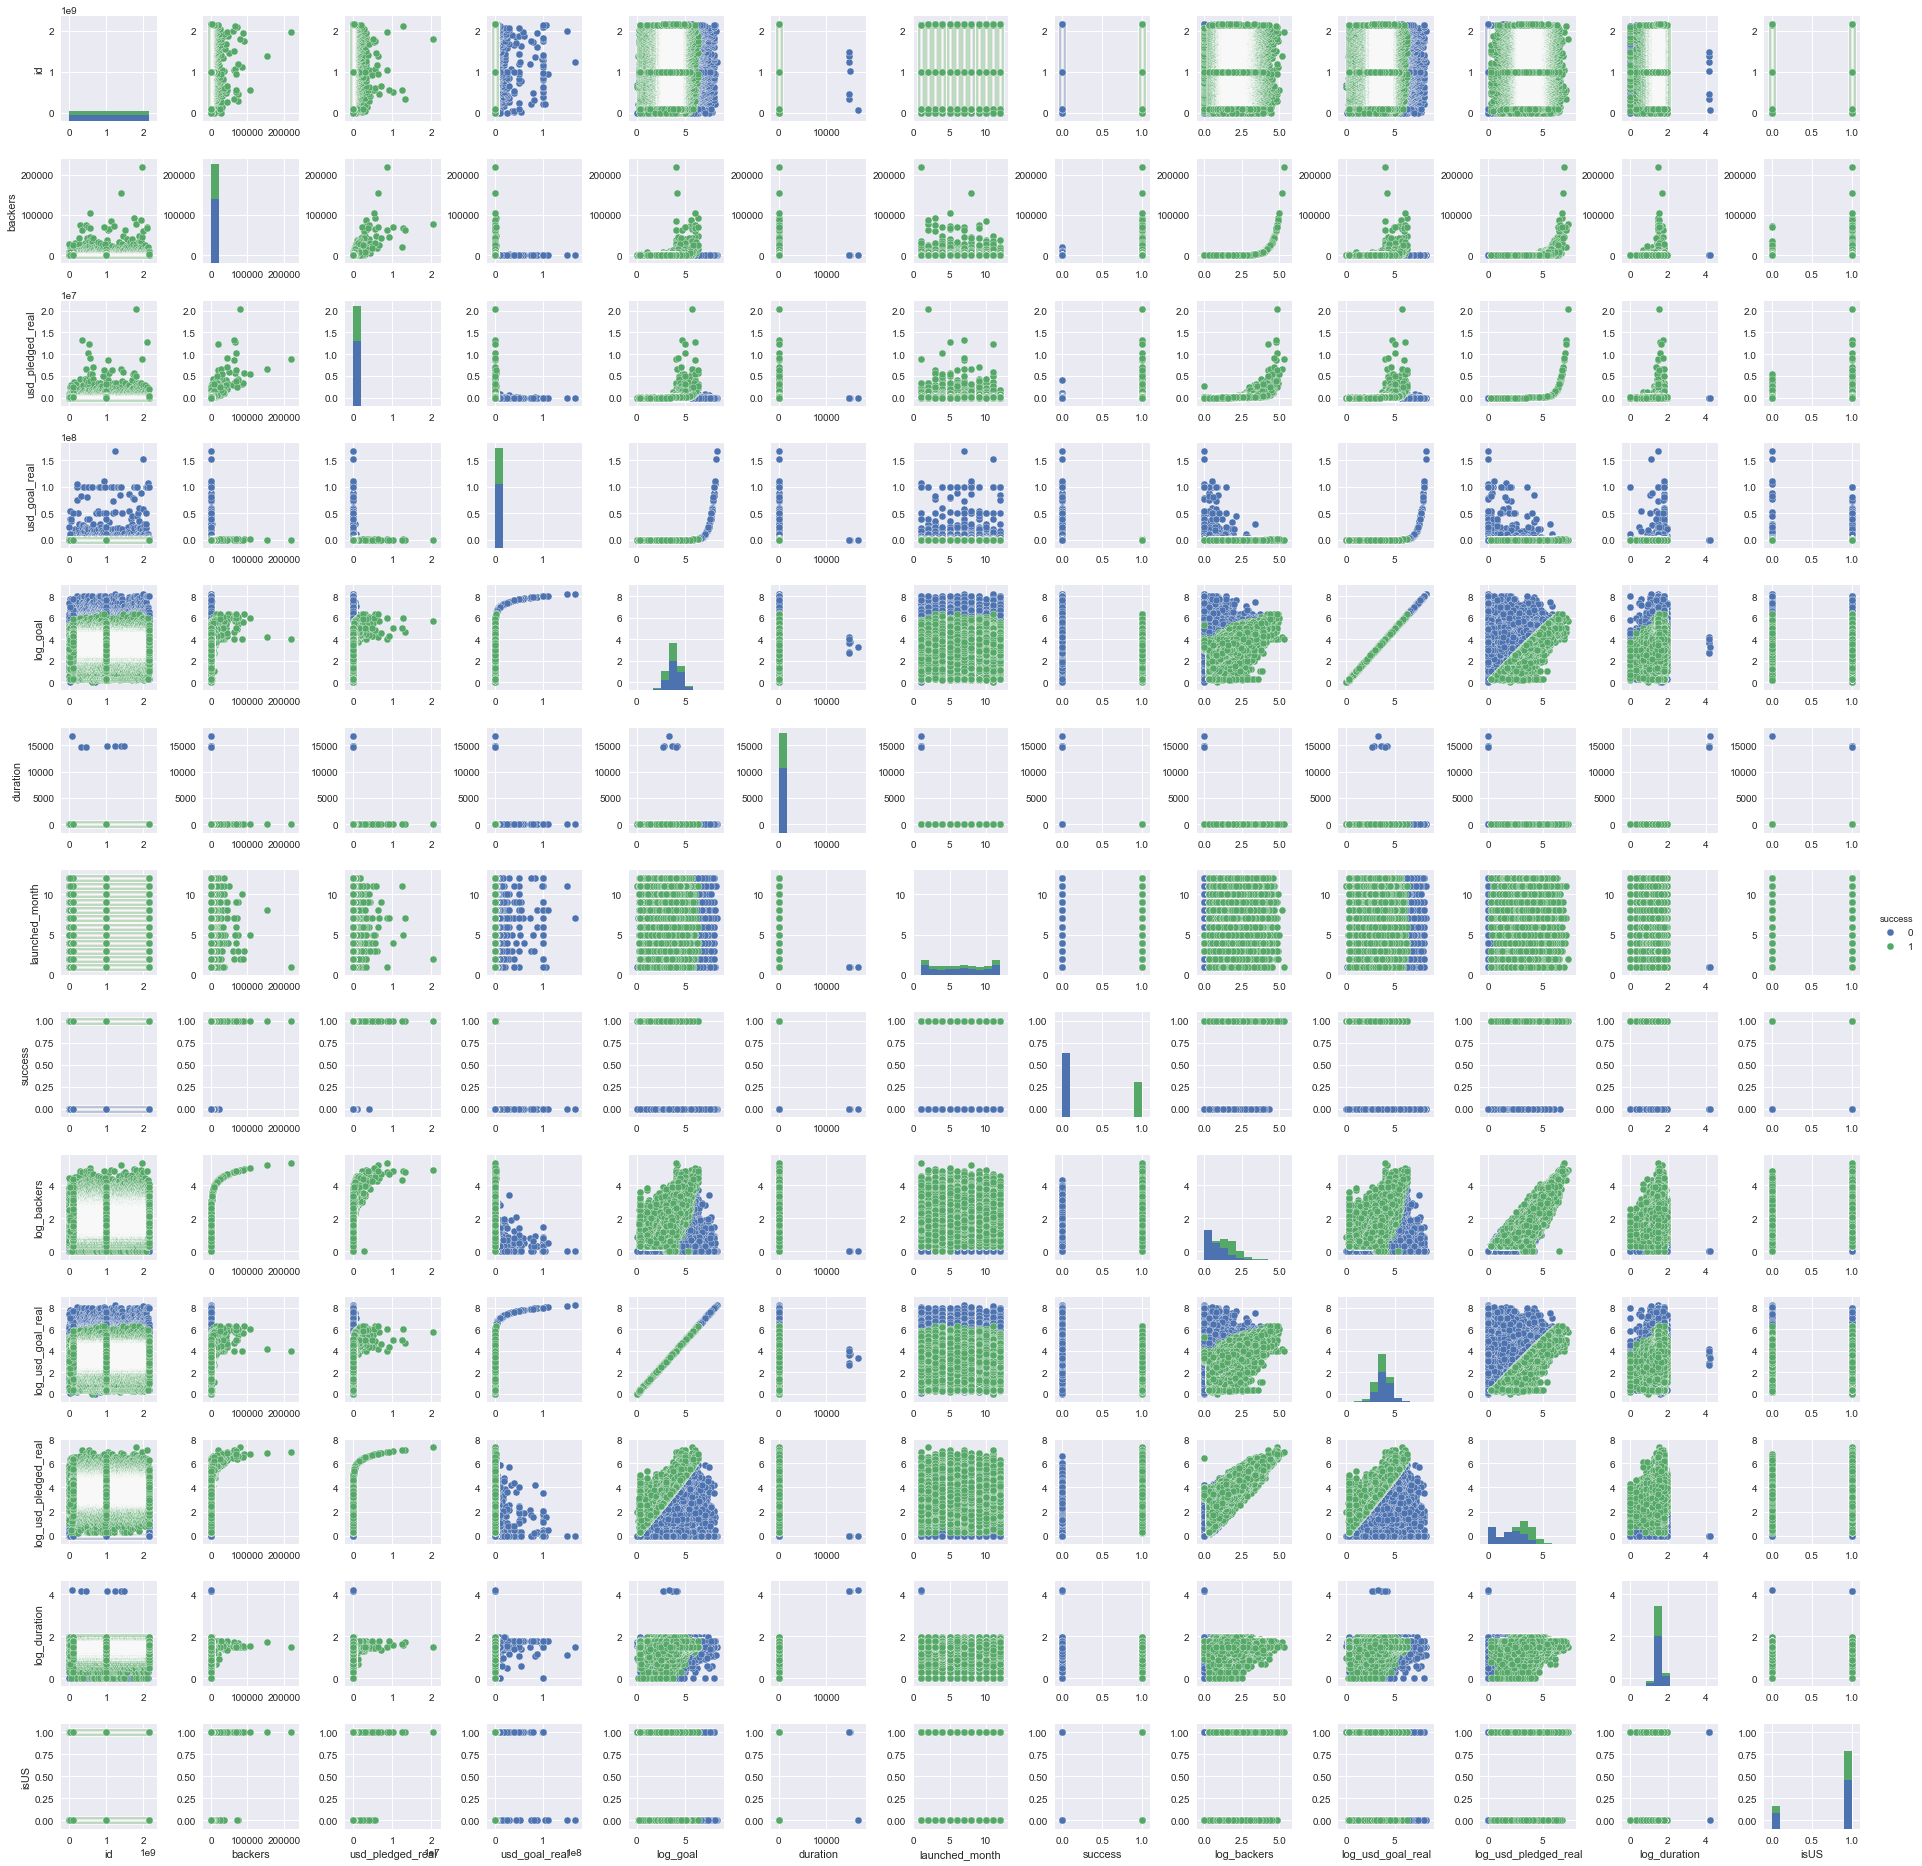

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

sns.pairplot(dfcopy, hue="success", size=2)

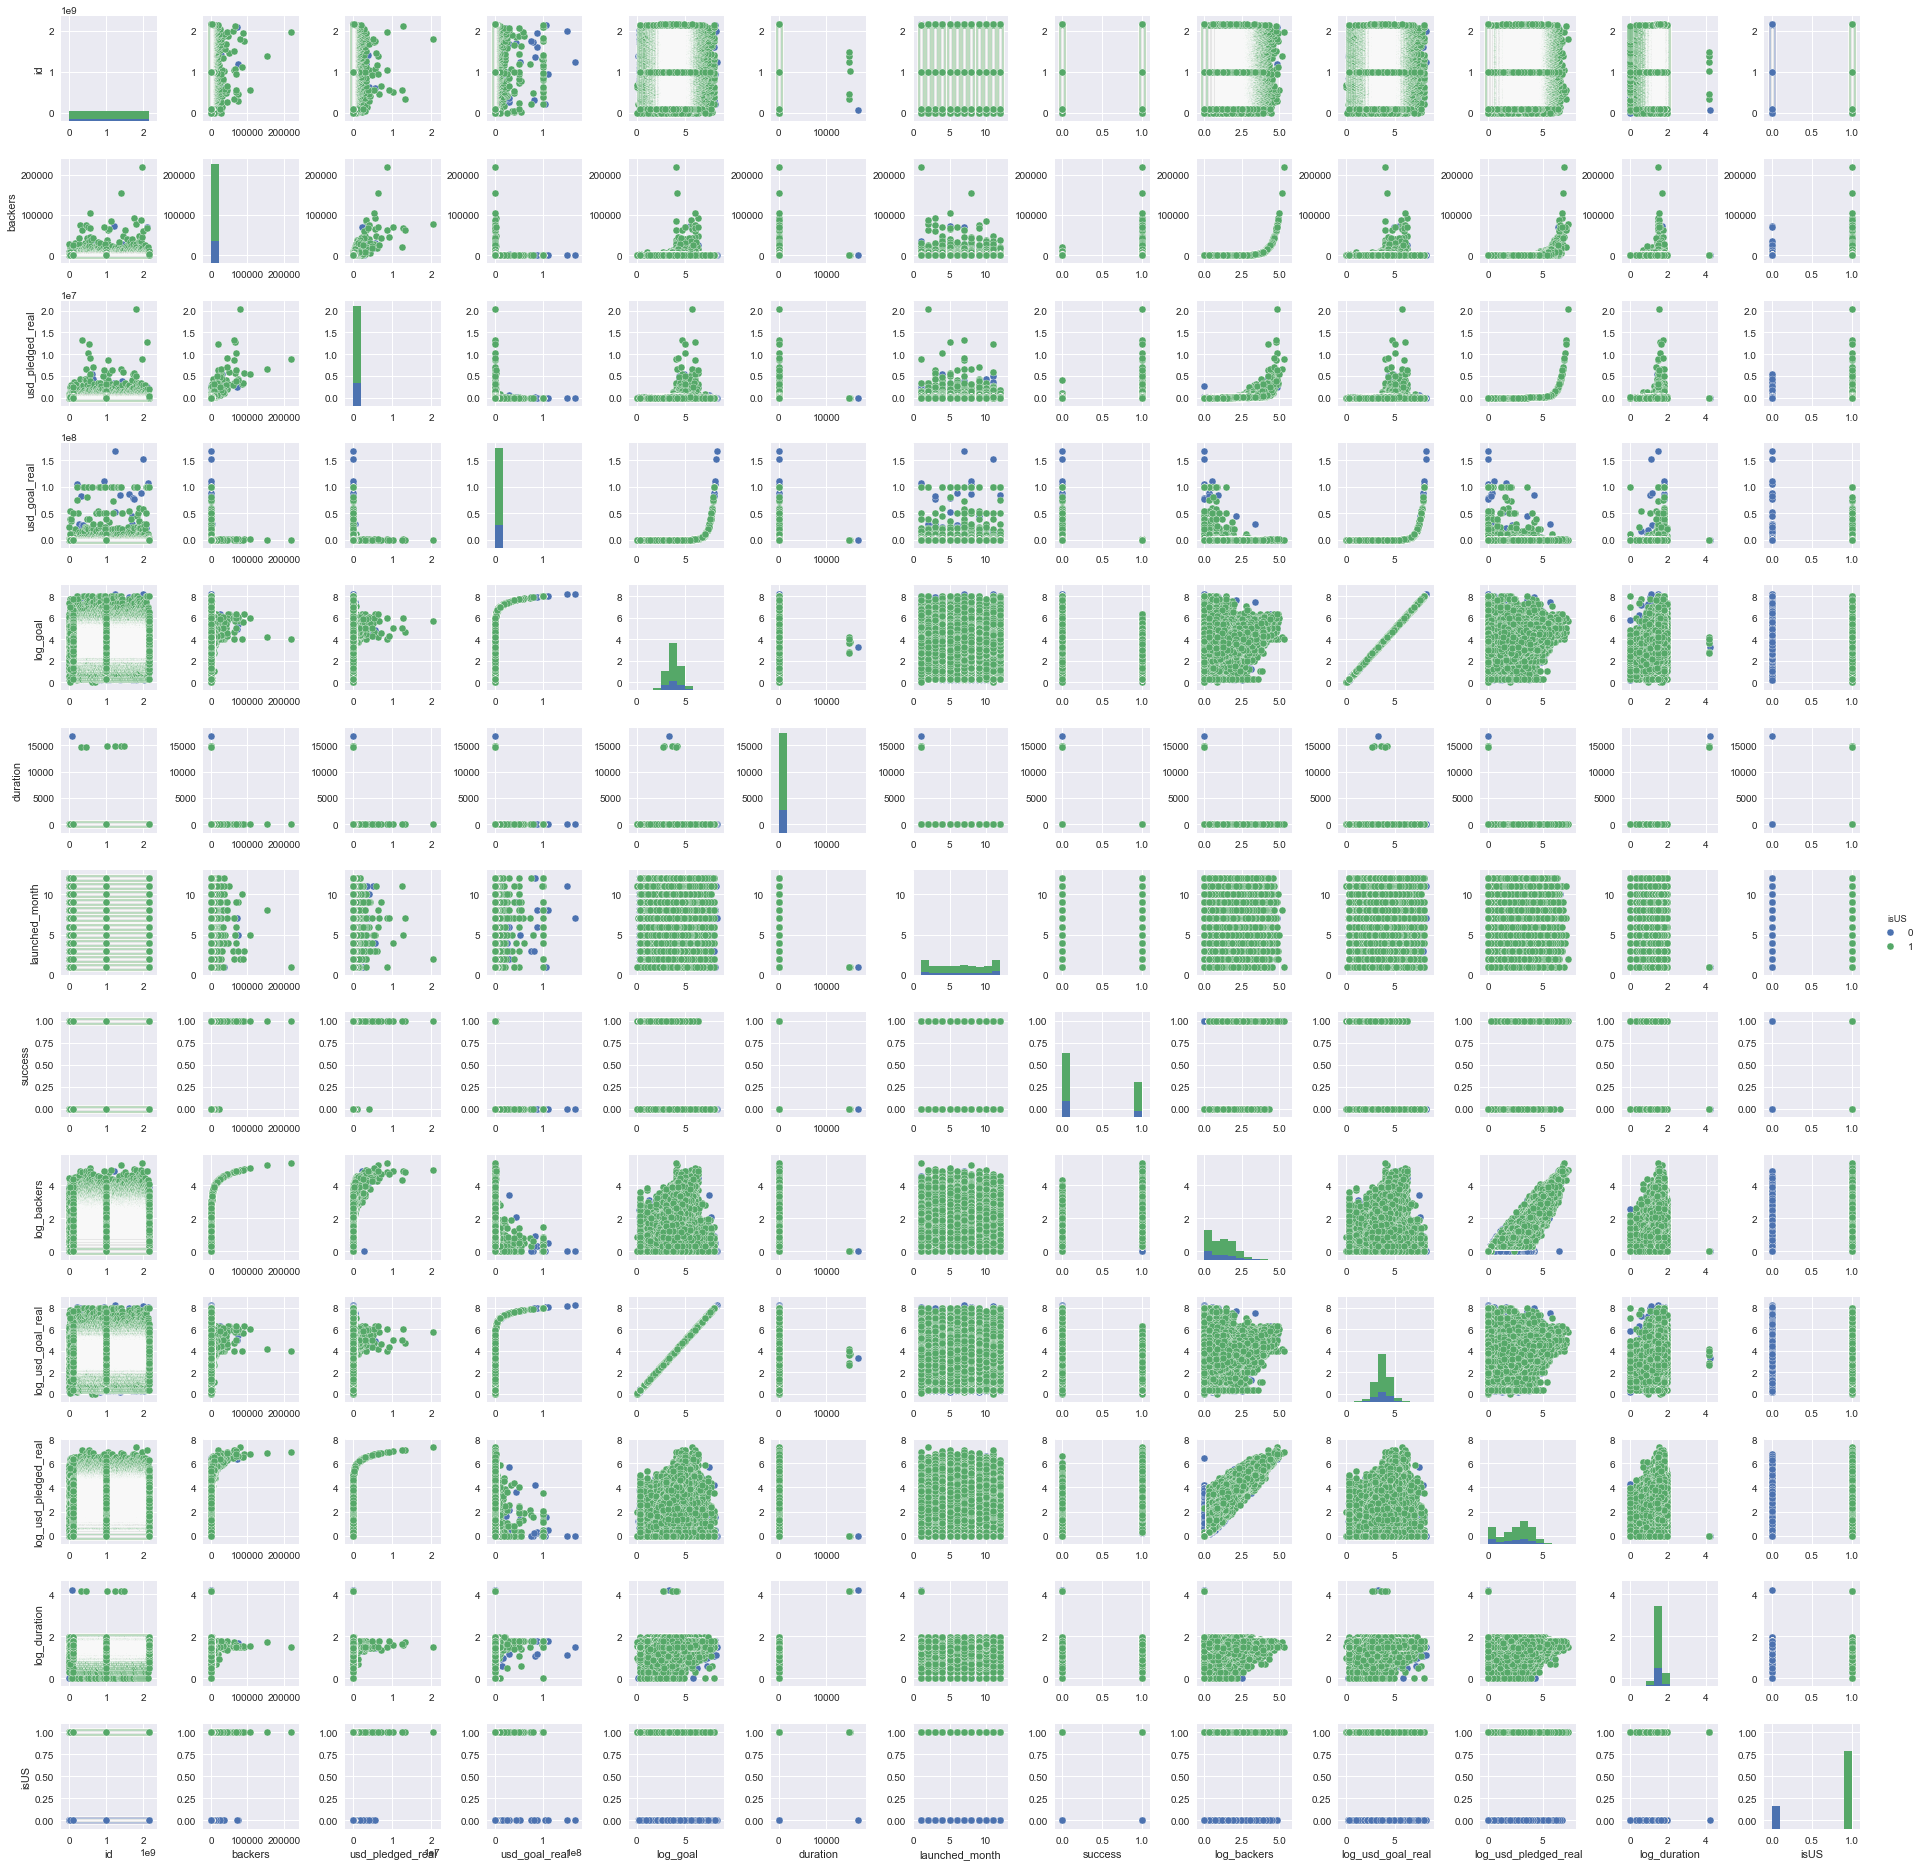

In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

sns.pairplot(dfcopy, hue="isUS", size=2)

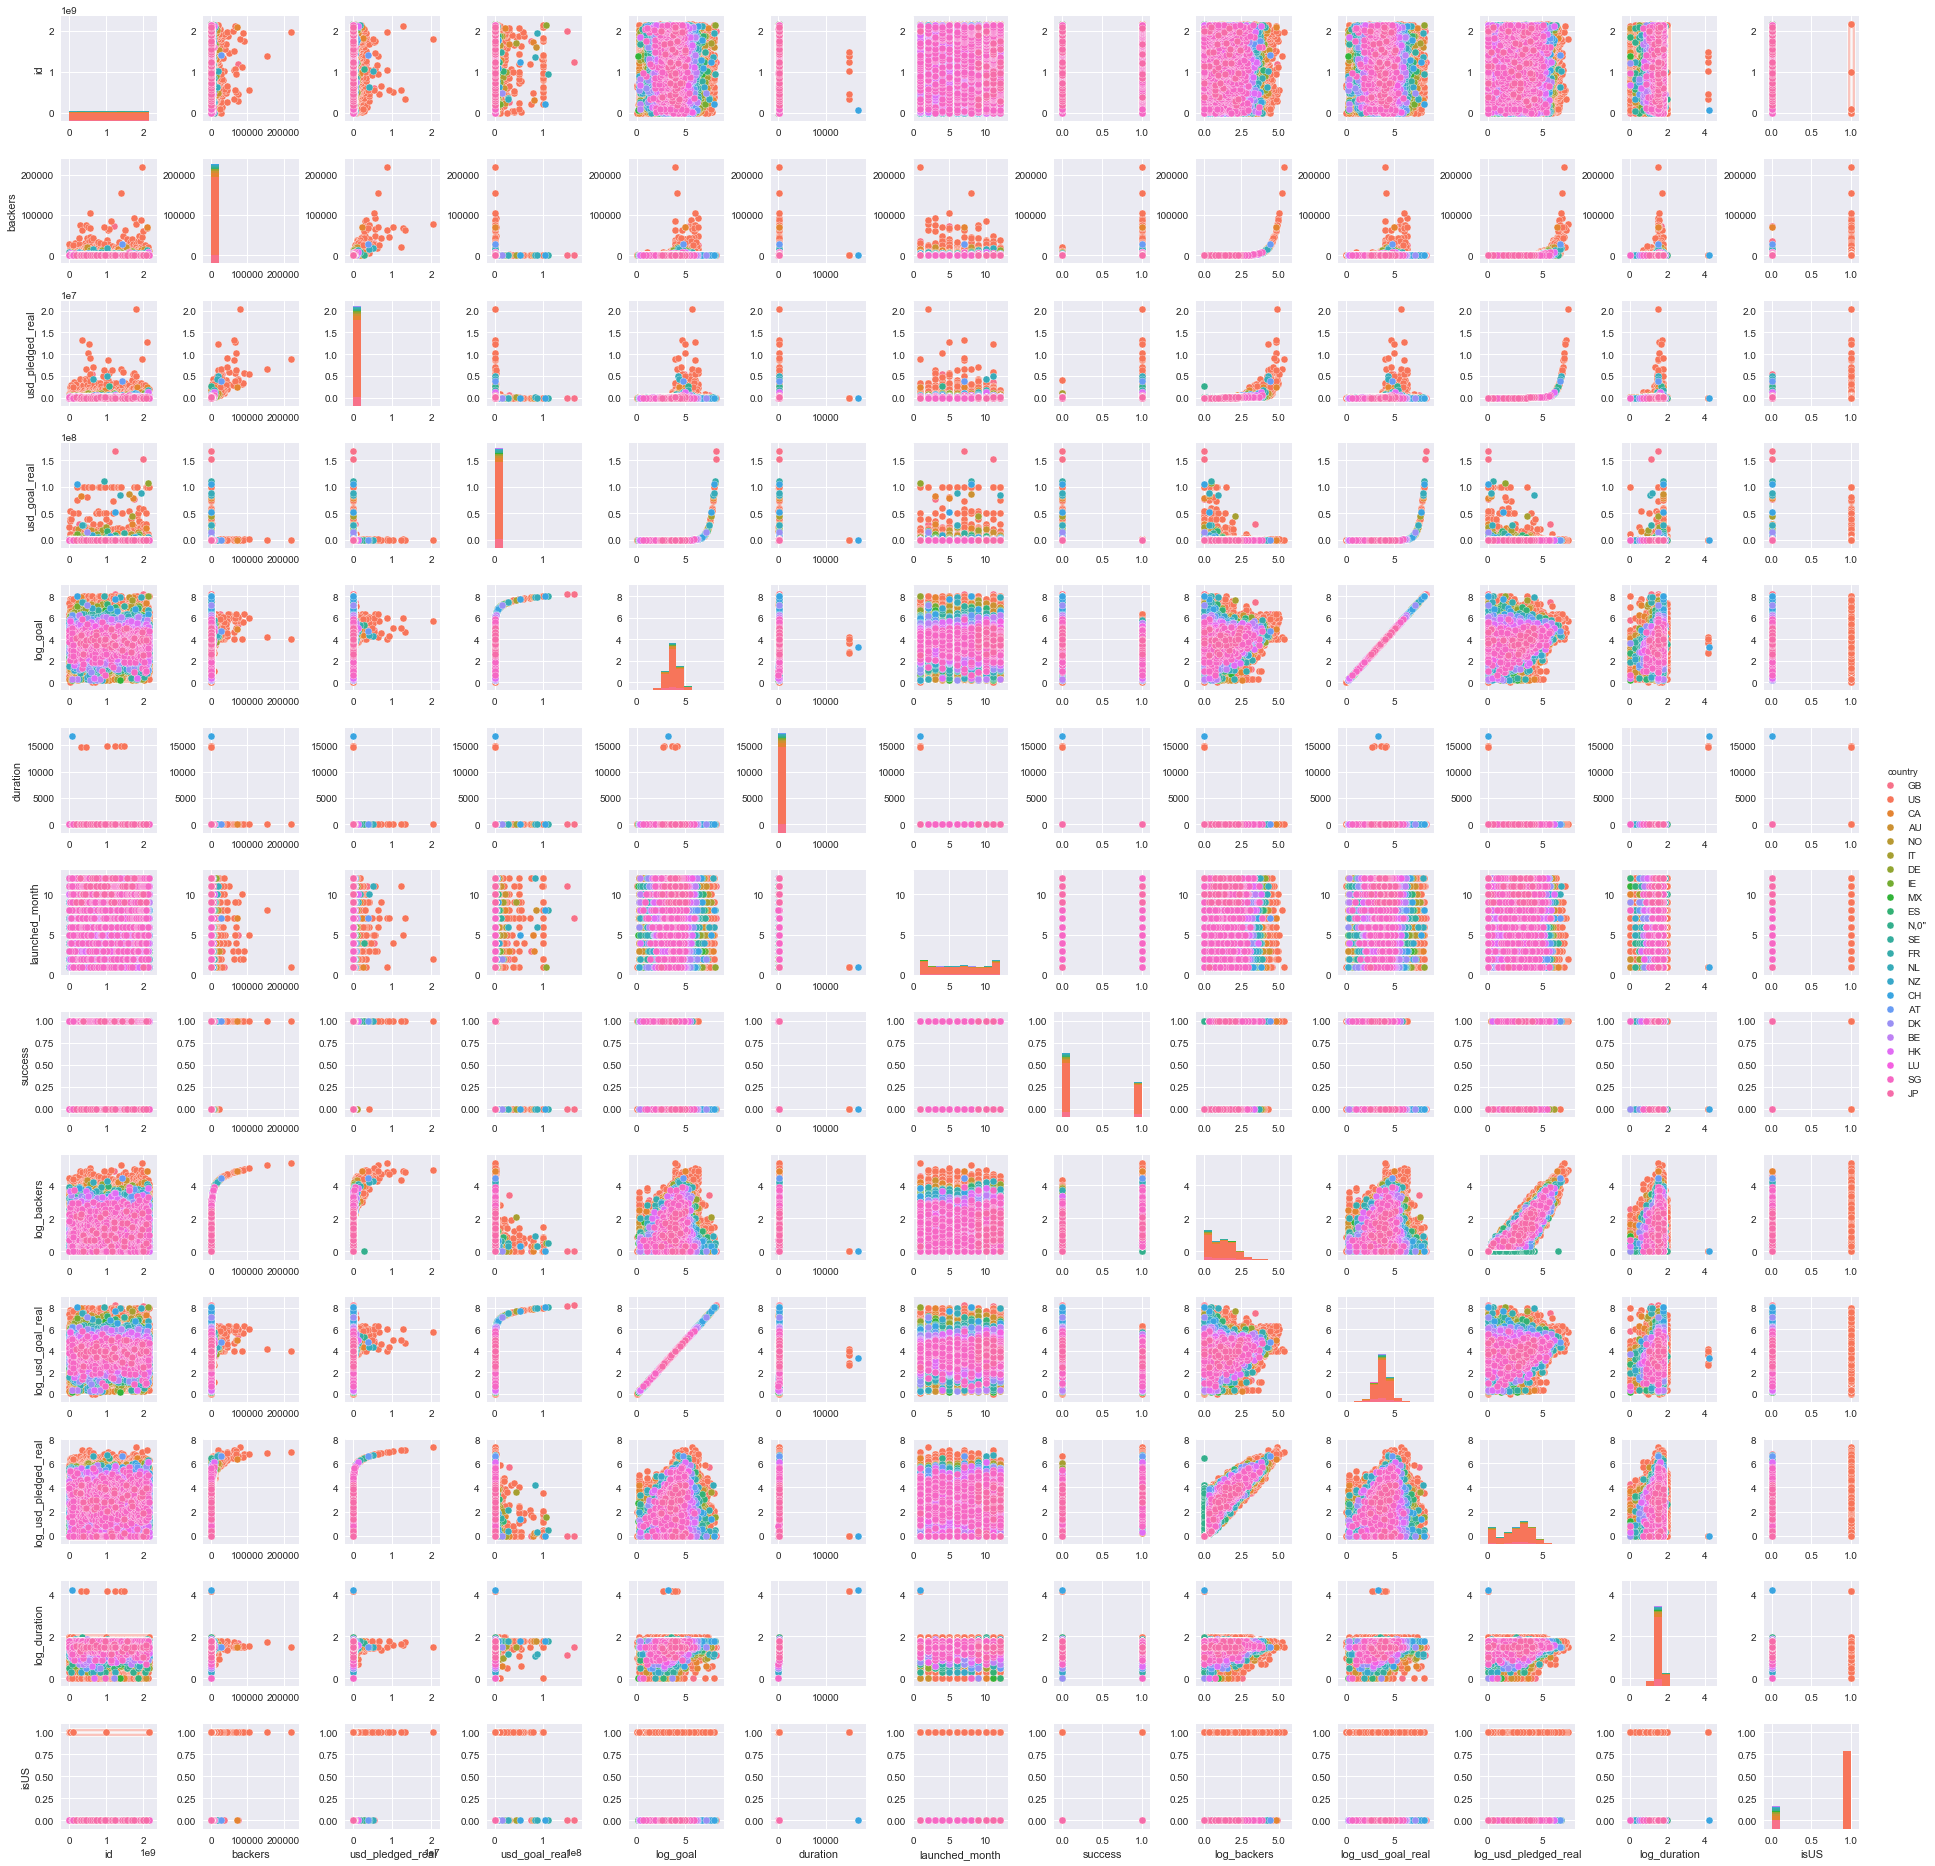

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

sns.pairplot(dfcopy, hue="country", size=2)

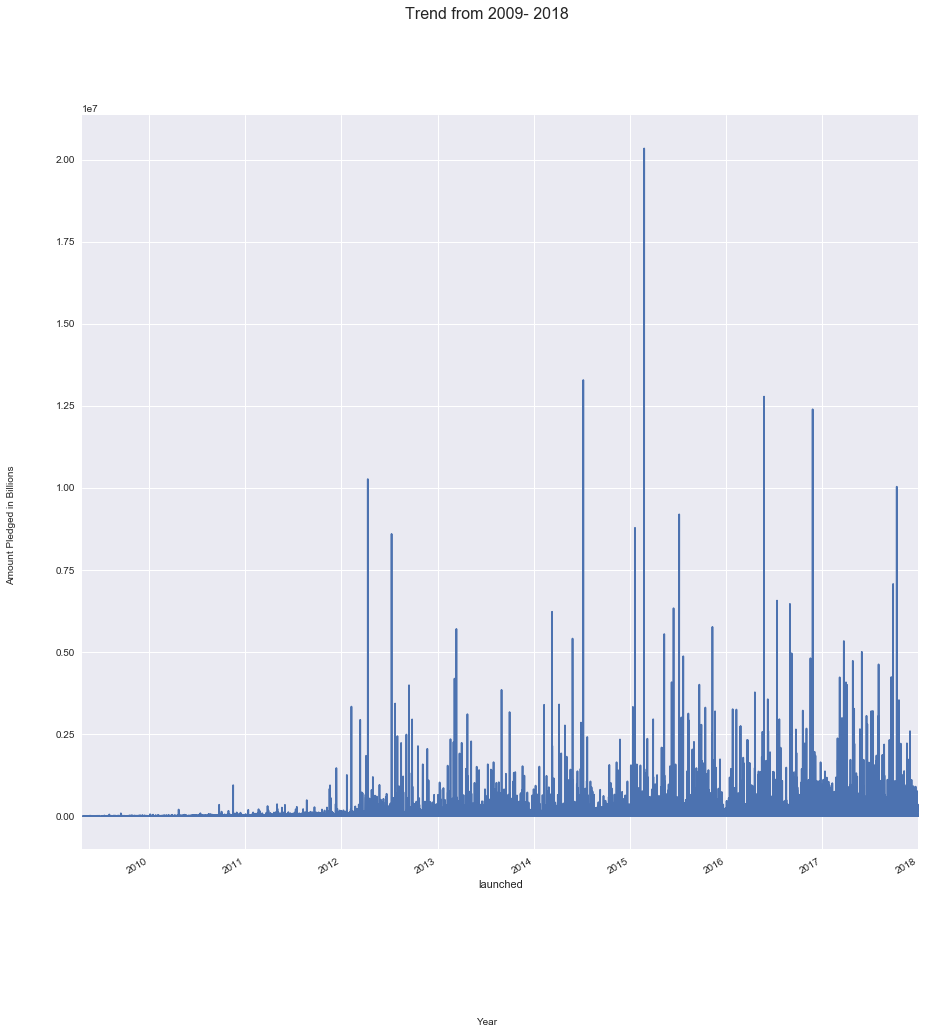

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
x = no_outliers.index  
y = no_outliers.pledged


fig, ax = plt.subplots( figsize = (15,15))
fig.suptitle('Trend from 2009- 2018', fontsize=16)
fig.text(0.5, 0.04, 'Year', ha='center', va='center')
fig.text(0.06, 0.5, 'Amount Pledged in Billions', ha='center', va='center', rotation='vertical')
no_outliers.pledged.plot(ax=ax)
plt.show()

**Comparison of Amount pledged vs Goal reached**
Resample the mean pledged every 12 months

Text(0,0.5,'Mean amount raised over year')

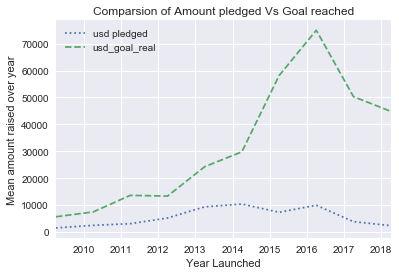

In [54]:
%matplotlib inline

no_outliers.usd_pledged.resample('12M').mean().plot( style=':')
no_outliers.usd_goal_real.resample('12M').mean().plot( style='--')
plt.legend(['usd pledged', 'usd_goal_real'], loc ='upper left')
plt.title('Comparsion of Amount pledged Vs Goal reached')
plt.xlabel('Year Launched')
plt.ylabel('Mean amount raised over year')

**Comparison of Amount pledged vs Goal reached**
Resample the mean pledged every 3 months

Text(0,0.5,'Mean amount raised over year')

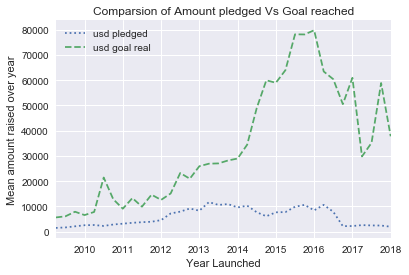

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

no_outliers.usd_pledged.resample('3M').mean().plot( style=':')
no_outliers.usd_goal_real.resample('3M').mean().plot( style='--')
plt.legend(['usd pledged', 'usd goal real'], loc ='upper left')
plt.title('Comparsion of Amount pledged Vs Goal reached')
plt.xlabel('Year Launched')
plt.ylabel('Mean amount raised over year')

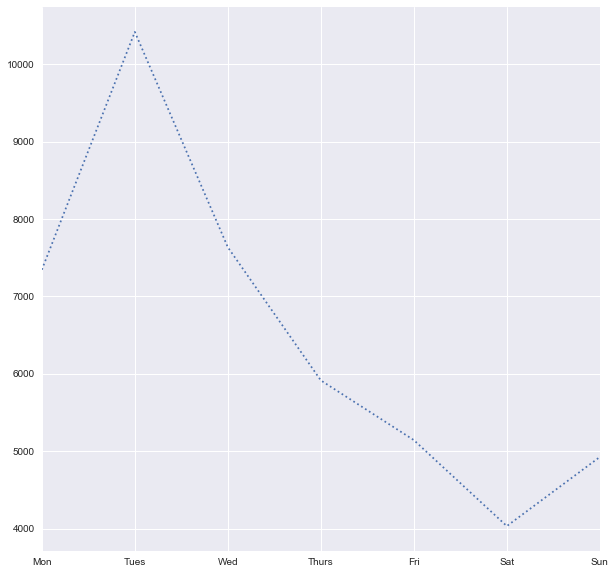

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))

wd =  no_outliers.usd_pledged.groupby(no_outliers.index.dayofweek).mean()
wd = no_outliers.usd_pledged.groupby(no_outliers.index.dayofweek).mean()

wd.index =['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

wd.plot(style=':')

### Conclusion

A very strong prediction of whether a Kickstarter campaign will be successful or not, can be made with attributes such as the number of backers and target price. Nonetheless, if somebody is looking to invest in a winning Kickstarter, then they should look at US base campaigns within the Arts' category. Furthermore, inventors looking to attract backers and essentially reaching their goal as fast as they can, should consider launching their campaign early in the week rather than the weekend. 